In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal
import math

# use fmDemodArctan and fmPlotPSD
from fmSupportLib import fmDemodArctan, fmPlotPSD, lpCoeff, own_lfilter, bpFirwin, fmPll
# for take-home add your functions

# the radio-frequency (RF) sampling rate
# this sampling rate is either configured on RF hardware
# or documented when a raw file with IQ samples is provided
rf_Fs = 2.4e6

# the cutoff frequency to extract the FM channel from raw IQ data
rf_Fc = 100e3

# the number of taps for the low-pass filter to extract the FM channel
# this default value for the width of the impulse response should be changed
# depending on some target objectives, like the width of the transition band
# and/or the minimum expected attenuation from the pass to the stop band
rf_taps = 101

# the decimation rate when reducing the front end sampling rate (i.e., RF)
# to a smaller samping rate at the intermediate frequency (IF) where
# the demodulated data will be split into the mono/stereo/radio data channels
rf_decim = 10

# audio sampling rate (we assume audio will be at 48 KSamples/sec)
audio_Fs = 48e3
# should be the same as rf_Fs / rf_decim / audio_decim

# complete your own settings for the mono channel
# (cutoff freq, audio taps, decimation rate, ...)
audio_Fc = 16e3 # change as needed (see spec in lab document)
audio_decim = 5 # change as needed (see spec in lab document)
audio_taps = 101 # change as you see fit

# flag that keeps track if your code is running for
# in-lab (il_vs_th = 0) vs takehome (il_vs_th = 1)
il_vs_th = 1

Read raw RF data from "../data/stereo_l0_r9.raw" in unsigned 8-bit format
Reformatted raw RF data to 32-bit float format (95027200 bytes)


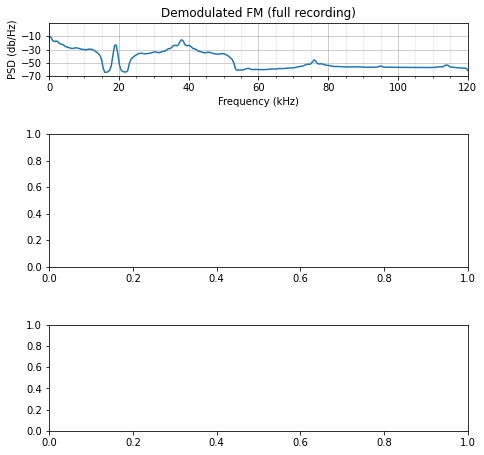

In [2]:
# read the raw IQ data from the recorded file
# IQ data is assumed to be in 8-bits unsigned (and interleaved)
in_fname = "../data/stereo_l0_r9.raw"
# in_fname = "/usr/raw_data/iq_samples/samples1.raw"

raw_data = np.fromfile(in_fname, dtype='uint8')
print("Read raw RF data from \"" + in_fname + "\" in unsigned 8-bit format")
	# IQ data is normalized between -1 and +1 in 32-bit float format
iq_data = (np.float32(raw_data) - 128.0)/128.0
print("Reformatted raw RF data to 32-bit float format (" + str(iq_data.size * iq_data.itemsize) + " bytes)")

	# coefficients for the front-end low-pass filter
rf_coeff = signal.firwin(rf_taps, rf_Fc/(rf_Fs/2), window=('hann'))

# filter to extract the FM channel (I samples are even, Q samples are odd)
i_filt = signal.lfilter(rf_coeff, 1.0, iq_data[0::2])
q_filt = signal.lfilter(rf_coeff, 1.0, iq_data[1::2])

# downsample the FM channel
i_ds = i_filt[::rf_decim]
q_ds = q_filt[::rf_decim]

# set up the subfigures for plotting
subfig_height = np.array([0.8, 2, 1.6]) # relative heights of the subfigures
plt.rc('figure', figsize=(7.5, 7.5))	# the size of the entire figure
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, gridspec_kw={'height_ratios': subfig_height})
fig.subplots_adjust(hspace = .6)

# FM demodulator (check the library)
fm_demod, dummy = fmDemodArctan(i_ds, q_ds)
# we use a dummy because there is no state for this single-pass model

fmPlotPSD(ax0, fm_demod, (rf_Fs/rf_decim)/1e3, subfig_height[0],\
			'Demodulated FM (full recording)')

In [3]:
audio_coeff = lpCoeff(Fs = (rf_Fs/rf_decim), Fc = audio_Fc, ntaps = audio_taps)
audio_filt = signal.lfilter(audio_coeff, 1.0, fm_demod)

stereo_coeff = bpFirwin((rf_Fs/rf_decim), 22e3, 54e3, 101)
stereo_data = signal.lfilter(stereo_coeff, 1.0, fm_demod)

In [4]:
pilot_coeff = bpFirwin((rf_Fs/rf_decim), 18.5e3, 20.5e3, 101)
pilot_data = signal.lfilter(pilot_coeff, 1.0, fm_demod)

In [5]:
ncoOut = fmPll(pilot_data, 19e3, rf_Fs/rf_decim, 2)

mixed_data = np.zeros(len(stereo_data))
# Stereo processing/demodulation
for i in range(len(stereo_data)):
	mixed_data[i] = ((stereo_data[i] * ncoOut[i]))

# cos(a)cos(b) = 1/2(cos(a-b) + cos(a+b)) we only need the cos(a-b) term
mixed_coeff = lpCoeff(Fs = (rf_Fs/rf_decim), Fc = 38e3, ntaps = 101)
mixed_data = signal.lfilter(mixed_coeff, 1.0, mixed_data)
mixed_data = 2 * mixed_data

mixed_data = mixed_data[::audio_decim]

# delay the mono audio by 101/2 samples
padding = np.zeros(50)
audio_filt = np.concatenate((padding, audio_filt[:-50]))


In [6]:


# you should uncomment the plots below once you have processed the data
# PSD after extracting mono audio
fmPlotPSD(ax1, audio_filt, (rf_Fs/rf_decim)/1e3, subfig_height[1], 'Extracted Mono')
# downsample audio data (see the principle for i_ds or q_ds)
audio_data = audio_filt[::audio_decim] # to be updated by you during in-lab (same code for takehome)

left_data = np.zeros(len(audio_data))
right_data = np.zeros(len(audio_data))

for i in range(len(audio_data)):
	left_data[i] = (audio_data[i] + mixed_data[i])
	right_data[i] = (audio_data[i] - mixed_data[i])

In [13]:
fmPlotPSD(ax2, audio_data, audio_Fs/1e3, subfig_height[2], 'Downsampled Mono Audio')
# save PSD plots
fig.savefig("../data/fmMonoBasic.png")
plt.show()
# write audio data to file (assumes audio_data samples are -1 to +1)
out_fname = "../data/fmMonoBasic_1.wav"
wavfile.write(out_fname, int(audio_Fs), np.int16((audio_data/2)*32767))
stereo_out_fname_left = "../data/fmMonoBasic_stereo_left.wav"
stereo_out_fname_right = "../data/fmMonoBasic_stereo_right.wav"
stereo_out_fname = '../data/fmMonoBasic_stereo.wav'
wavfile.write(stereo_out_fname_left, int(audio_Fs), np.int16((left_data/2)*32767))
wavfile.write(stereo_out_fname_right, int(audio_Fs), np.int16((right_data/2)*32767))
c = np.column_stack((np.int16((left_data/2)*32767), np.int16((right_data/2)*32767)))
print(c)
wavfile.write(stereo_out_fname, int(audio_Fs), c)
# during FM transmission audio samples in the mono channel will contain
# the sum of the left and right audio channels; hence, we first
# divide by two the audio sample value and then we rescale to fit
# in the range offered by 16-bit signed int representation
print("Written audio samples to \"" + out_fname + "\" in signed 16-bit format")

[[     0      0]
 [     0      0]
 [     0      0]
 ...
 [  6843 -10347]
 [  5428  -4706]
 [  3241  -1413]]
Written audio samples to "../data/fmMonoBasic_1.wav" in signed 16-bit format
